In [1]:
!pip install -q nevergrad optuna

# Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import nevergrad as ng
import optuna

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas as pd
from collections import defaultdict

# For reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed()

# Load the Data

In [3]:
def load_data(batch_size=64):
    """
    Loads the FashionMNIST dataset with the specified batch size.

    Args:
        batch_size (int): Number of samples per batch.

    Returns:
        tuple: Train and test DataLoader objects.
    """
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    return train_loader, test_loader

In [4]:
def visualize_samples(train_loader):
    """
    Visualizes the first 6 samples from the training dataset.

    Args:
        train_loader (DataLoader): DataLoader for the training dataset.
    """
    examples = enumerate(train_loader)
    batch_idx, (example_data, example_targets) = next(examples)

    fig = plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(example_data[i][0], cmap='gray')
        plt.title(f"Label: {example_targets[i]}")
        plt.axis('off')
    plt.show()

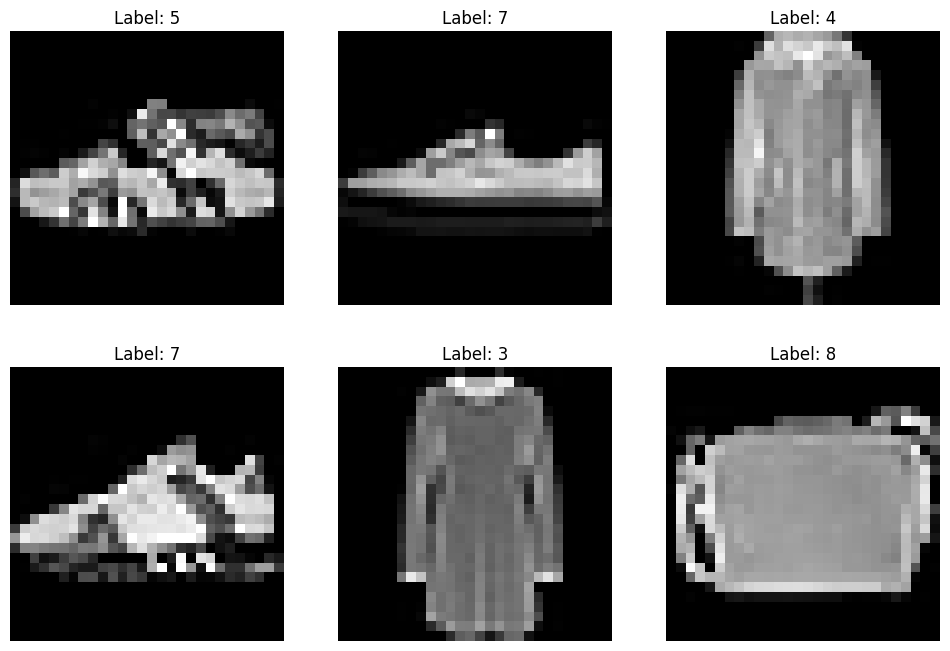

In [5]:
# Load data
train_loader_default, test_loader = load_data()
visualize_samples(train_loader_default)

# Define the Model

In [6]:
# Define the Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, activation_function):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation_function = activation_function

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.activation_function(self.fc1(x))
        x = self.fc2(x)
        return x

# Define Training & Evaluation Functions

In [7]:
def train_epoch(model, device, train_loader, criterion, optimizer):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The neural network model.
        device (torch.device): Device to run the training on.
        train_loader (DataLoader): DataLoader for the training dataset.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [8]:
def evaluate(model, device, test_loader, criterion):
    """
    Evaluates the model on the test dataset.

    Args:
        model (nn.Module): The neural network model.
        device (torch.device): Device to run the evaluation on.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (nn.Module): Loss function.

    Returns:
        tuple: Average test loss and accuracy.
    """
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    return test_loss, accuracy

# Nevergrad Optimization

In [9]:
def objective_ng(learning_rate, batch_size, activation_function):
    """
    Objective function for Nevergrad hyperparameter optimization.

    Args:
        learning_rate (float): Learning rate for the optimizer.
        batch_size (int): Batch size for the DataLoader.
        activation_function (str): Activation function name.

    Returns:
        float: Negative accuracy on the test set.
    """
    # Set seed for reproducibility
    set_seed()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()

    # Map activation function string to actual function
    activation_functions = {
        'relu': F.relu,
        'sigmoid': torch.sigmoid,
        'tanh': torch.tanh
    }
    activation_fn = activation_functions[activation_function]

    # Load data with the given batch size
    train_loader, _ = load_data(batch_size=int(batch_size))

    # Initialize the model and optimizer
    model = SimpleMLP(activation_function=activation_fn).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train the model for one epoch
    train_epoch(model, device, train_loader, criterion, optimizer)

    # Evaluate the model
    eval_loss, accuracy = evaluate(model, device, test_loader, criterion)

    print(f"Learning Rate: {learning_rate:.6f}, Batch Size: {int(batch_size)}, Activation Function: {activation_function}")
    print(f"Test Loss: {eval_loss:.4f}, Accuracy: {accuracy:.2f}%\n")

    return -accuracy  # Negative because we minimize the objective

In [10]:
def run_nevergrad_optimization(budget=20):
    """
    Runs hyperparameter optimization using Nevergrad.

    Args:
        budget (int): Number of function evaluations.

    Returns:
        tuple: Results dictionary, best hyperparameters, and best loss.
    """
    # Define the parametrization
    parametrization = ng.p.Instrumentation(
        learning_rate=ng.p.Log(lower=1e-3, upper=1e-1),
        batch_size=ng.p.Scalar(lower=4, upper=128).set_integer_casting(),
        activation_function=ng.p.Choice(['relu', 'sigmoid', 'tanh'])  # Use strings instead of functions
    )

    # Initialize the optimizer
    optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=budget)

    # Collect results
    results_ng = defaultdict(list)

    # Optimization loop
    for _ in range(budget):
        x = optimizer.ask()
        loss = objective_ng(*x.args, **x.kwargs)
        optimizer.tell(x, loss)

        # Record the results
        results_ng['learning_rate'].append(x.kwargs['learning_rate'])
        results_ng['batch_size'].append(x.kwargs['batch_size'])
        results_ng['activation_function'].append(x.kwargs['activation_function'])
        results_ng['loss'].append(loss)

    # Get the best hyperparameters
    recommendation = optimizer.provide_recommendation()
    best_hparams = recommendation.kwargs
    best_loss = recommendation.loss

    return results_ng, best_hparams, best_loss

In [11]:
# Run Nevergrad optimization
results_ng, best_hparams_ng, best_loss_ng = run_nevergrad_optimization(budget=20)

# Display the best hyperparameters
print("Best Hyperparameters from Nevergrad:")
for key, value in best_hparams_ng.items():
    print(f"{key}: {value}")

print(f"\nBest Accuracy: {-best_loss_ng:.2f}%")

Learning Rate: 0.010000, Batch Size: 66, Activation Function: sigmoid
Test Loss: 1.5456, Accuracy: 59.16%

Learning Rate: 0.010412, Batch Size: 75, Activation Function: sigmoid
Test Loss: 1.6061, Accuracy: 57.27%

Learning Rate: 0.013532, Batch Size: 55, Activation Function: tanh
Test Loss: 0.6751, Accuracy: 76.46%

Learning Rate: 0.002269, Batch Size: 14, Activation Function: relu
Test Loss: 0.7659, Accuracy: 71.73%

Learning Rate: 0.003471, Batch Size: 55, Activation Function: sigmoid
Test Loss: 2.0349, Accuracy: 54.81%

Learning Rate: 0.013532, Batch Size: 96, Activation Function: relu
Test Loss: 0.7958, Accuracy: 70.26%

Learning Rate: 0.013532, Batch Size: 31, Activation Function: sigmoid
Test Loss: 0.9472, Accuracy: 69.66%

Learning Rate: 0.013532, Batch Size: 55, Activation Function: sigmoid
Test Loss: 1.2346, Accuracy: 63.94%

Learning Rate: 0.013532, Batch Size: 62, Activation Function: sigmoid
Test Loss: 1.3063, Accuracy: 62.18%

Learning Rate: 0.013532, Batch Size: 55, Activ

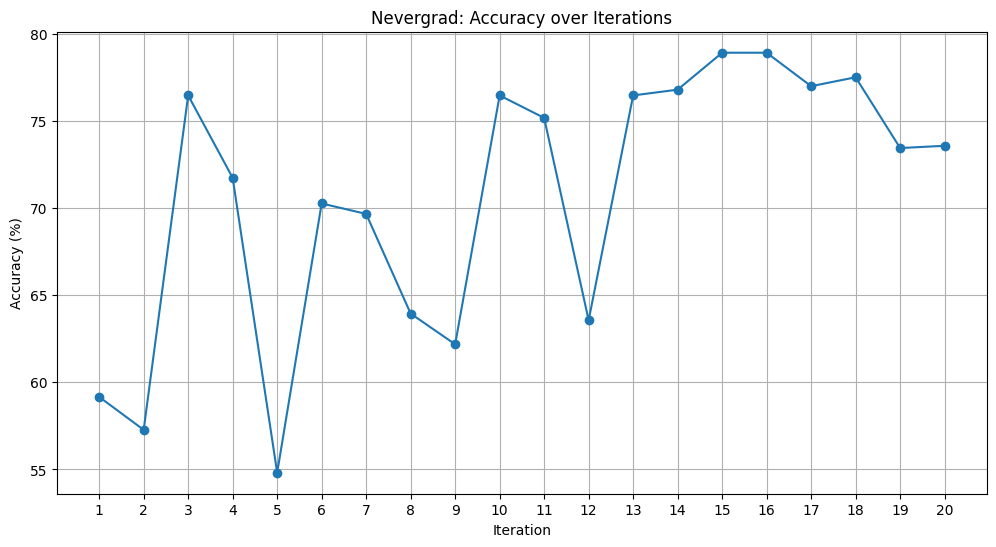

In [12]:
# Convert results to DataFrame
df_results_ng = pd.DataFrame(results_ng)

# Plot accuracy over iterations
def plot_accuracy_over_iterations(df_results, title):
    """
    Plots accuracy over optimization iterations.

    Args:
        df_results (DataFrame): DataFrame containing optimization results.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(-df_results['loss'], marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')

    # Set x-ticks to integer values corresponding to iterations
    iterations = range(1, len(df_results) + 1)
    plt.xticks(ticks=range(len(df_results)), labels=iterations)

    plt.grid(True)
    plt.show()

plot_accuracy_over_iterations(df_results_ng, 'Nevergrad: Accuracy over Iterations')

# Optuna Optimization

In [13]:
def objective_optuna(trial):
    """
    Objective function for Optuna hyperparameter optimization.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.

    Returns:
        float: Accuracy on the test set.
    """
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size', 4, 128)
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'sigmoid', 'tanh'])  # Use strings

    # Set seed for reproducibility
    set_seed()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()

    # Map activation function string to actual function
    activation_functions = {
        'relu': F.relu,
        'sigmoid': torch.sigmoid,
        'tanh': torch.tanh
    }
    activation_fn = activation_functions[activation_function]

    # Load data with the suggested batch size
    train_loader, _ = load_data(batch_size=int(batch_size))

    # Initialize the model and optimizer
    model = SimpleMLP(activation_function=activation_fn).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train the model for one epoch
    train_epoch(model, device, train_loader, criterion, optimizer)

    # Evaluate the model
    eval_loss, accuracy = evaluate(model, device, test_loader, criterion)

    # Report intermediate value
    trial.report(accuracy, step=0)

    # Handle pruning if using pruners
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    print(f"Learning Rate: {learning_rate:.6f}, Batch Size: {int(batch_size)}, Activation Function: {activation_function}")
    print(f"Test Loss: {eval_loss:.4f}, Accuracy: {accuracy:.2f}%\n")

    return accuracy  # Optuna maximizes the objective by default

In [14]:
def run_optuna_optimization(n_trials=20):
    """
    Runs hyperparameter optimization using Optuna.

    Args:
        n_trials (int): Number of trials for the optimization.

    Returns:
        tuple: Results dictionary, best hyperparameters, and best accuracy.
    """
    study = optuna.create_study(direction='maximize')

    # Collect results
    results_optuna = defaultdict(list)

    def callback(study, trial):
        # Record the results
        results_optuna['learning_rate'].append(trial.params['learning_rate'])
        results_optuna['batch_size'].append(trial.params['batch_size'])
        results_optuna['activation_function'].append(trial.params['activation_function'])
        results_optuna['accuracy'].append(trial.value)

    # Run optimization
    study.optimize(objective_optuna, n_trials=n_trials, callbacks=[callback])

    best_hparams = study.best_params
    best_accuracy = study.best_value

    return results_optuna, best_hparams, best_accuracy

In [15]:
# Run Optuna optimization
results_optuna, best_hparams_optuna, best_accuracy_optuna = run_optuna_optimization(n_trials=20)

# Display the best hyperparameters
print("Best Hyperparameters from Optuna:")
for key, value in best_hparams_optuna.items():
    print(f"{key}: {value}")

print(f"\nBest Accuracy: {best_accuracy_optuna:.2f}%")

[I 2024-10-20 06:12:41,369] A new study created in memory with name: no-name-fed705f5-7c33-4aa2-bde7-044436b73c39
[I 2024-10-20 06:12:49,348] Trial 0 finished with value: 76.96 and parameters: {'learning_rate': 0.014289872641535849, 'batch_size': 42, 'activation_function': 'relu'}. Best is trial 0 with value: 76.96.


Learning Rate: 0.014290, Batch Size: 42, Activation Function: relu
Test Loss: 0.6407, Accuracy: 76.96%



[I 2024-10-20 06:12:56,875] Trial 1 finished with value: 61.89 and parameters: {'learning_rate': 0.0012882824565155283, 'batch_size': 61, 'activation_function': 'relu'}. Best is trial 0 with value: 76.96.


Learning Rate: 0.001288, Batch Size: 61, Activation Function: relu
Test Loss: 1.6909, Accuracy: 61.89%



[I 2024-10-20 06:13:10,855] Trial 2 finished with value: 79.63 and parameters: {'learning_rate': 0.08824214695102627, 'batch_size': 9, 'activation_function': 'tanh'}. Best is trial 2 with value: 79.63.


Learning Rate: 0.088242, Batch Size: 9, Activation Function: tanh
Test Loss: 0.6075, Accuracy: 79.63%



[I 2024-10-20 06:13:18,860] Trial 3 finished with value: 64.0 and parameters: {'learning_rate': 0.010394641640204802, 'batch_size': 43, 'activation_function': 'sigmoid'}. Best is trial 2 with value: 79.63.


Learning Rate: 0.010395, Batch Size: 43, Activation Function: sigmoid
Test Loss: 1.2448, Accuracy: 64.00%



[I 2024-10-20 06:13:28,406] Trial 4 finished with value: 65.55 and parameters: {'learning_rate': 0.005927271630937026, 'batch_size': 22, 'activation_function': 'sigmoid'}. Best is trial 2 with value: 79.63.


Learning Rate: 0.005927, Batch Size: 22, Activation Function: sigmoid
Test Loss: 1.1827, Accuracy: 65.55%



[I 2024-10-20 06:13:35,892] Trial 5 pruned. 
[I 2024-10-20 06:13:44,257] Trial 6 finished with value: 73.01 and parameters: {'learning_rate': 0.01737498491641585, 'batch_size': 33, 'activation_function': 'relu'}. Best is trial 2 with value: 79.63.


Learning Rate: 0.017375, Batch Size: 33, Activation Function: relu
Test Loss: 0.7451, Accuracy: 73.01%



[I 2024-10-20 06:13:51,996] Trial 7 finished with value: 73.59 and parameters: {'learning_rate': 0.009503234251978647, 'batch_size': 48, 'activation_function': 'relu'}. Best is trial 2 with value: 79.63.


Learning Rate: 0.009503, Batch Size: 48, Activation Function: relu
Test Loss: 0.7242, Accuracy: 73.59%



[I 2024-10-20 06:14:02,951] Trial 8 finished with value: 80.24 and parameters: {'learning_rate': 0.009460892953301466, 'batch_size': 15, 'activation_function': 'relu'}. Best is trial 8 with value: 80.24.


Learning Rate: 0.009461, Batch Size: 15, Activation Function: relu
Test Loss: 0.5656, Accuracy: 80.24%



[I 2024-10-20 06:14:10,714] Trial 9 pruned. 
[I 2024-10-20 06:14:17,666] Trial 10 finished with value: 79.3 and parameters: {'learning_rate': 0.04238445503475761, 'batch_size': 104, 'activation_function': 'tanh'}. Best is trial 8 with value: 80.24.


Learning Rate: 0.042384, Batch Size: 104, Activation Function: tanh
Test Loss: 0.5940, Accuracy: 79.30%



[I 2024-10-20 06:14:35,473] Trial 11 finished with value: 80.12 and parameters: {'learning_rate': 0.067910731288234, 'batch_size': 6, 'activation_function': 'tanh'}. Best is trial 8 with value: 80.24.


Learning Rate: 0.067911, Batch Size: 6, Activation Function: tanh
Test Loss: 0.5905, Accuracy: 80.12%



[I 2024-10-20 06:14:55,347] Trial 12 finished with value: 81.76 and parameters: {'learning_rate': 0.03323672287866346, 'batch_size': 5, 'activation_function': 'tanh'}. Best is trial 12 with value: 81.76.


Learning Rate: 0.033237, Batch Size: 5, Activation Function: tanh
Test Loss: 0.5175, Accuracy: 81.76%



[I 2024-10-20 06:15:02,295] Trial 13 finished with value: 77.78 and parameters: {'learning_rate': 0.03220011429066317, 'batch_size': 97, 'activation_function': 'tanh'}. Best is trial 12 with value: 81.76.


Learning Rate: 0.032200, Batch Size: 97, Activation Function: tanh
Test Loss: 0.6277, Accuracy: 77.78%



[I 2024-10-20 06:15:09,137] Trial 14 pruned. 
[I 2024-10-20 06:15:18,759] Trial 15 pruned. 
[I 2024-10-20 06:15:28,408] Trial 16 pruned. 
[I 2024-10-20 06:15:35,540] Trial 17 finished with value: 80.82 and parameters: {'learning_rate': 0.053747045256532844, 'batch_size': 83, 'activation_function': 'tanh'}. Best is trial 12 with value: 81.76.


Learning Rate: 0.053747, Batch Size: 83, Activation Function: tanh
Test Loss: 0.5464, Accuracy: 80.82%



[I 2024-10-20 06:15:42,700] Trial 18 finished with value: 80.67 and parameters: {'learning_rate': 0.04871684206415513, 'batch_size': 83, 'activation_function': 'tanh'}. Best is trial 12 with value: 81.76.


Learning Rate: 0.048717, Batch Size: 83, Activation Function: tanh
Test Loss: 0.5543, Accuracy: 80.67%



[I 2024-10-20 06:15:49,892] Trial 19 pruned. 


Best Hyperparameters from Optuna:
learning_rate: 0.03323672287866346
batch_size: 5
activation_function: tanh

Best Accuracy: 81.76%


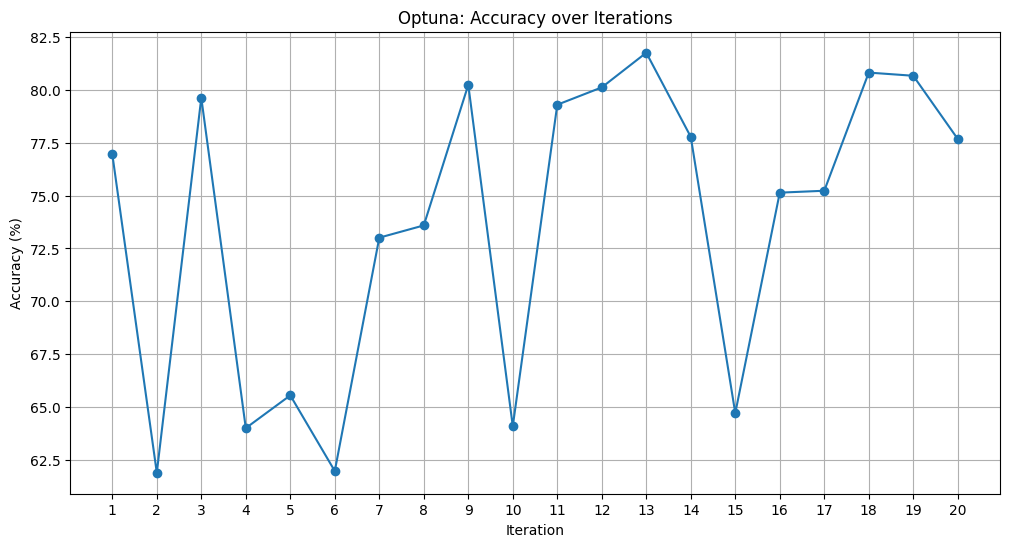

In [16]:
# Convert results to DataFrame
df_results_optuna = pd.DataFrame(results_optuna)

# Plot accuracy over iterations
def plot_accuracy_over_iterations_optuna(df_results, title):
    """
    Plots accuracy over Optuna optimization iterations.

    Args:
        df_results (DataFrame): DataFrame containing Optuna optimization results.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df_results.index, df_results['accuracy'], marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')

    # Set x-ticks to integer values corresponding to iterations
    iterations = range(1, len(df_results) + 1)
    plt.xticks(ticks=range(len(df_results)), labels=iterations)

    plt.grid(True)
    plt.show()

plot_accuracy_over_iterations_optuna(df_results_optuna, 'Optuna: Accuracy over Iterations')

# Compare the Results

In [17]:
# Combine results
df_results_ng['Optimizer'] = 'Nevergrad'
df_results_optuna['Optimizer'] = 'Optuna'

# Rename columns for consistency
df_results_ng_renamed = df_results_ng.rename(columns={'loss': 'objective'})
df_results_optuna_renamed = df_results_optuna.rename(columns={'accuracy': 'objective'})

# Adjust objective values for comparison
df_results_ng_renamed['objective'] = -df_results_ng_renamed['objective']  # Convert back to positive accuracy

# Assign iteration numbers
df_results_ng_renamed['Iteration'] = range(1, len(df_results_ng_renamed) + 1)
df_results_optuna_renamed['Iteration'] = range(1, len(df_results_optuna_renamed) + 1)

# Add to a combined DataFrame
df_combined_ng = df_results_ng_renamed[['Iteration', 'objective', 'Optimizer']]
df_combined_optuna = df_results_optuna_renamed[['Iteration', 'objective', 'Optimizer']]
df_combined = pd.concat([df_combined_ng, df_combined_optuna], ignore_index=True)

# Determine the maximum number of iterations for setting x-ticks
max_iterations = max(df_combined['Iteration'])

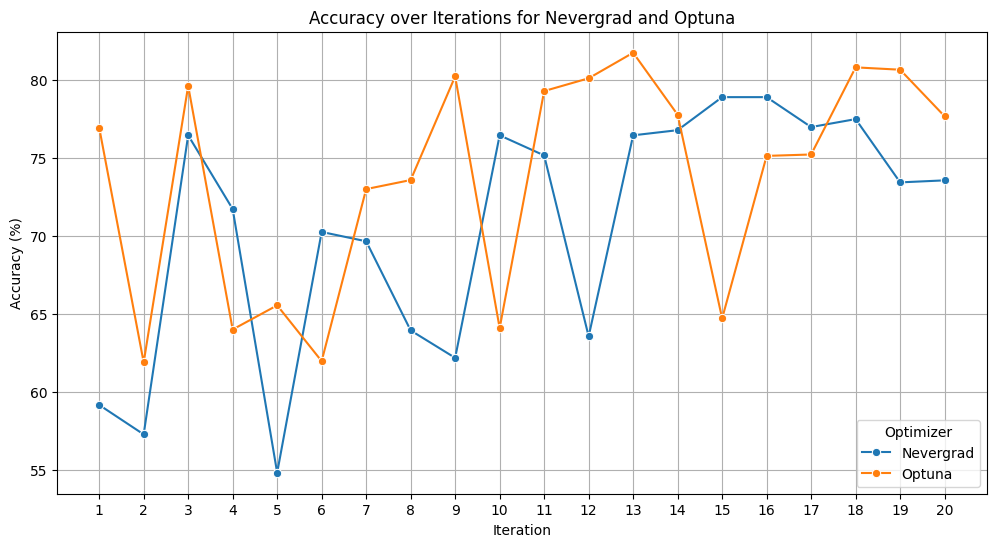

In [18]:
# Plot accuracy over iterations for both optimizers
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='Iteration', y='objective', hue='Optimizer', marker='o', linestyle='-')
plt.title('Accuracy over Iterations for Nevergrad and Optuna')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')

# Set x-ticks to integer values corresponding to iterations
plt.xticks(ticks=range(1, max_iterations + 1), labels=range(1, max_iterations + 1))

plt.grid(True)
plt.show()

In [19]:
# Add Optimizer info to both DataFrames
df_results_ng['Optimizer'] = 'Nevergrad'
df_results_optuna['Optimizer'] = 'Optuna'

# Combine for boxplot
df_box = pd.concat([
    df_results_ng.rename(columns={'activation_function': 'activation_function', 'loss': 'objective'}),
    df_results_optuna.rename(columns={'activation_function': 'activation_function', 'accuracy': 'objective'})
])

# Adjust objective values
df_box.loc[df_box['Optimizer'] == 'Nevergrad', 'objective'] = -df_box.loc[df_box['Optimizer'] == 'Nevergrad', 'objective']

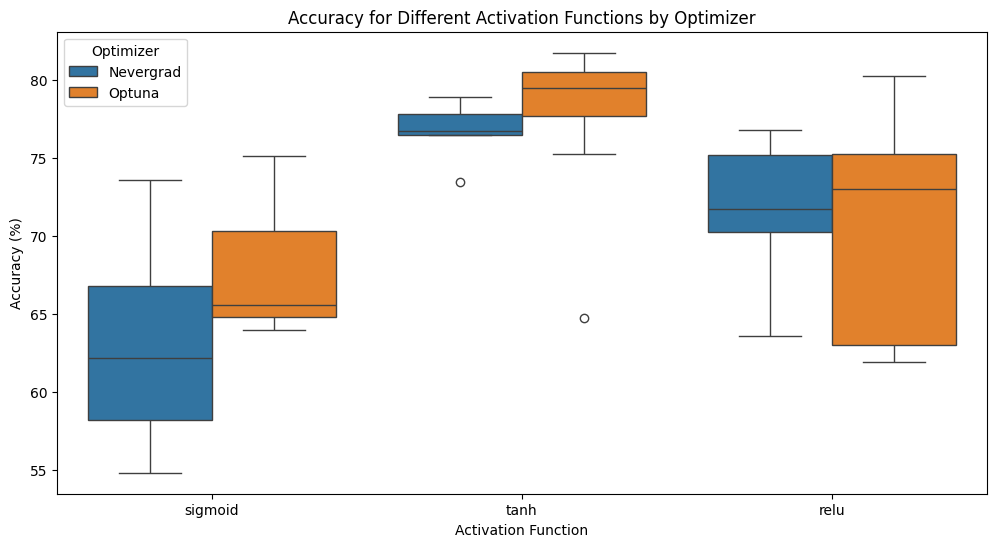

In [20]:
# Box plot for activation functions
plt.figure(figsize=(12, 6))
sns.boxplot(x='activation_function', y='objective', hue='Optimizer', data=df_box)
plt.title('Accuracy for Different Activation Functions by Optimizer')
plt.xlabel('Activation Function')
plt.ylabel('Accuracy (%)')
plt.legend(title='Optimizer')
plt.show()